# Introduction

In [112]:
import requests
from bs4 import BeautifulSoup
import datetime
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
import urllib.request
import matplotlib
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, ward, average, centroid, complete, weighted
from sklearn import metrics

In [ ]:
averaged together all popularity scores by genre to remove variance due to individual artist popularity
normalized by the sum of each genre score to remove baseline differences in popularity of events
between cities (i.e. events in Manhattan are always going to be more "popular" than events in)

# Import data

I will use each Billboard's top 100 emerging artists list, as published on a weekly basis from 2018 to early 2020, to generate a list of several hundred artists whose tour itineraries I will pull from Songkick.

## Scrape list of emerging artists from Billboard
### Create list of all dates in 2018, 2019, and early 2020 that fall on a Saturday (for concatenation with URL)

In [2]:
# SOURCE:  https://stackoverflow.com/questions/993358/creating-a-range-of-dates-in-python
# compile list of every saturday in 2019 and Jan-Feb 2020, in Year-Month-Day format

weeks = []

start = datetime.datetime.strptime("2018-01-06", "%Y-%m-%d")
end = datetime.datetime.strptime("2020-02-29", "%Y-%m-%d")
date_generated = [start + datetime.timedelta(weeks=x) for x in range(0, (end-start).days)]

for date in date_generated:
    weeks.append(date.strftime("%Y-%m-%d"))
    
weeks = weeks[0:113]

In [3]:
print(weeks[0])
print(weeks[112])

2018-01-06
2020-02-29


### Scrape names of top 50 emerging artists for each week in date list, removing duplicates

In [4]:
artists_scrape = []

for w in weeks:
    url = 'https://www.billboard.com/charts/emerging-artists/' + w
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    artistsoup = soup.find_all('div', class_='item-details__title')
    for a in artistsoup:
        name = a.get_text()
        if name in artists_scrape:
            continue
        else:
            artists_scrape.append(name)

In [5]:
len(artists_scrape)

829

In [6]:
artists_scrape

['LANCO',
 'Russell Dickerson',
 'MAX',
 'Walker Hayes',
 'Lil Xan',
 'Zacari',
 'YBN Nahmir',
 'Trippie Redd',
 'Devin Dawson',
 'GoldLink',
 'Zendaya',
 'Jacquees',
 'Tay-K',
 'Logan Paul',
 'Lil Baby',
 'Tee Grizzley',
 'Lauv',
 'Louis Tomlinson',
 'Lil Skies',
 'Sofi Tukker',
 'Dylan Scott',
 'Christian Nodal',
 'Big Shaq',
 'Alice Merton',
 'Swae Lee',
 'High Valley',
 'Bhad Bhabie',
 'Jordan Davis',
 'Anitta',
 'Alan Walker',
 'Greta Van Fleet',
 'Wanna One',
 'The Revivalists',
 'AJR',
 'YFN Lucci',
 'HRVY',
 'Famous Dex',
 'Carly Pearce',
 "Auli'i Cravalho",
 'Yung Bleu',
 'Natti Natasha',
 'Keala Settle',
 'TakeOff',
 'DeJ Loaf',
 'Nego do Borel',
 'MONSTA X',
 'Loren Allred',
 'Sabrina Carpenter',
 'Alta Consigna',
 "Rag'n'Bone Man",
 'The Bellas',
 'Blac Youngsta',
 'Jeff Rosenstock',
 'Andra Day',
 'Just Chase',
 'Lexy Panterra',
 'Chris Lane',
 'watt',
 'Morgan Wallen',
 'Sebastian Yatra',
 'Tauren Wells',
 'Nacho',
 'Billie Eilish',
 'Rita Ora',
 'Watain',
 'Layton Greene

In [7]:
# MANUAL COPY OF ARTIST LIST, WITH KAREN GIBSON REMOVED (HER CHOIR PERFORMANCE AT HARRY AND MEGAN'S WEDDING 
# WENT VIRAL, RESULTING IN HER CHART PLACEMENT ON BILLBOARDS EMERGING ARTISTS LIST)

artistlist = ['LANCO', 'Russell Dickerson', 'MAX', 'Walker Hayes', 'Lil Xan', 'Zacari', 'YBN Nahmir', 'Trippie Redd',
 'Devin Dawson', 'GoldLink', 'Zendaya', 'Jacquees', 'Tay-K', 'Logan Paul', 'Lil Baby', 'Tee Grizzley', 'Lauv',
 'Louis Tomlinson', 'Lil Skies', 'Sofi Tukker', 'Dylan Scott', 'Christian Nodal', 'Big Shaq', 'Alice Merton',
 'Swae Lee', 'High Valley', 'Bhad Bhabie', 'Jordan Davis', 'Anitta', 'Alan Walker', 'Greta Van Fleet', 'Wanna One',
 'The Revivalists', 'AJR', 'YFN Lucci', 'HRVY', 'Famous Dex', 'Carly Pearce', "Auli'i Cravalho", 'Yung Bleu',
 'Natti Natasha', 'Keala Settle', 'TakeOff', 'DeJ Loaf', 'Nego do Borel', 'MONSTA X', 'Loren Allred', 'Sabrina Carpenter',
 'Alta Consigna', "Rag'n'Bone Man", 'The Bellas', 'Blac Youngsta', 'Jeff Rosenstock', 'Andra Day', 'Just Chase',
 'Lexy Panterra', 'Chris Lane', 'watt', 'Morgan Wallen', 'Sebastian Yatra', 'Tauren Wells', 'Nacho', 'Billie Eilish',
 'Rita Ora', 'Watain', 'Layton Greene', "Derez De'Shon", 'Landon Cube', 'Anderson East', 'Avatar', 'Typhoon',
 'Tonight Alive', 'Ansel Elgort', 'Bazzi', 'Ty Tabor', 'GENTRI', 'Rich The Kid', 'EDEN', 'Cane Hill', 'Caleb + Kelsey',
 'tUnE-YaRdS', 'Queen Naija', 'Jason Manns', 'H.E.R.', 'Bad Wolves', 'Bahamas', 'Moon Taxi', 'Cory Asbury', 'Waterparks',
 'Ty Segall', 'Red Velvet', 'Evidence', 'Mike Shinoda', 'Tiny Moving Parts', 'Kali Uchis', 'Sleeping Giant', 'The Dangerous Summer',
 'Madison Beer', 'Rhye', "Why Don't We", 'Bishop Briggs', 'The Wood Brothers', 'Jon Langston', 'SOB X RBE', 'The Wombats',
 'Saudi', 'Good Tiger', 'DJ Kass', 'Jorja Smith', 'Anne-Marie', 'Jordan Feliz', "I'm With Her", 'Car Seat Headrest',
 'Slaves', 'Normani', 'The Plot In You', 'Superchunk', '6LACK', 'American Nightmare', 'Pianos Become The Teeth', 'John Corabi',
 'Agust D', 'j-hope', 'Dessa', 'Turnstile', 'Big Smo', 'Screaming Females', 'Phonte', 'Tracey Thorn', 'Lucius',
 'Calum Scott', 'Titus Andronicus', 'Joyner Lucas', 'Superorganism', 'The Band Of Heathens', 'Moose Blood', 'Trixie Mattel',
 'Stefflon Don', 'lovelytheband', 'PRhyme', 'Adam Calhoun', 'NCT', 'Rich Homie Quan', 'Hot Snakes', 'Ella Mai',
 'Saweetie', 'Rivers Of Nihil', 'Chiquis Rivera', 'DOROTHY', 'Todrick Hall', 'Paul Thorn', 'Dynamite Dylan', 'Lissie',
 'Ashley McBryde', 'Light The Torch', 'The Voidz', 'Gesaffelstein', 'Red Sun Rising', 'King Gizzard And The Lizard Wizard', 'Jukebox The Ghost',
 'Dr. Octagon', 'Allen Stone', 'Hop Along', 'Alina Baraz', 'The Aquabats!', 'Unknown Mortal Orchestra', 'Wye Oak',
 'Poo Bear', 'LEDGER', 'Prof', 'El Chombo', 'Raymix', 'Nekrogoblikon', 'From Ashes To New', 'Drew Love', 'TesseracT',
 'Morgan Evans', 'My Silent Bravery', 'Tammy Rivera', 'Mason Ramsey', 'Pryor Baird', 'Britton Buchanan', 'NCT 127',
 'Stray Kids', 'Frank Turner', 'Trampled By Turtles', 'Shakey Graves', 'Black Moth Super Rainbow', 'Wolfine', 'Juice WRLD',
 'Slim Jxmmi', 'The Word Alive', 'Kyla Jade', 'Drake White', 'Brynn Cartelli', 'Kaleb Lee', 'Brent Cobb', 'Joji',
 'Spensha Baker', 'Lindsay Ell', 'Two Feet', 'Sheku Kanneh-Mason', 'Maddie Poppe', 'Kris Wu', 'Parquet Courts',
 'Iration', 'Dana Fuchs', 'Trent Harmon', 'Caleb Lee Hutchinson', 'Gabby Barrett', 'Gunna', 'Influence Music',
 'Jackson Wang', 'Tyla Yaweh', 'Graveyard', 'Jude Demorest', 'Skepta', 'DJ SPINKING']

In [49]:
len(artistlist)

218

## Pull artist genre classifiers from Spotify API

In [21]:
auth_manager = SpotifyClientCredentials(client_id='ea51f4db67cf4a808dde1a9851ccd19e', 
                                        client_secret='048f383d092747fe8b9d3aa6914f0a3c')
sp = spotipy.Spotify(auth_manager=auth_manager)

### Retrieve artist URI codes

In [22]:
# Query spotipy for all artist URI codes

uri_list = []

for a in artistlist:
    result = sp.search(a)
    try:
        artist_uri = result['tracks']['items'][0]['artists'][0]['uri']
        uri_list.append(artist_uri)
    except:
        print(a)
        pass

In [23]:
len(uri_list)

218

### Retrieve artist genres using URI codes

In [24]:
# Use artist URI codes to query spotipy for each artist's associated genres

genrelist = []

for u in uri_list:
    genres = sp.artist(u)['genres']
    genrelist.append(genres)

In [25]:
len(genrelist)

218

In [26]:
d = {'artist':artists, 'genre':genrelist}
genre_df = pd.DataFrame(d)
genre_df.head()

,artist,genre
0,LANCO,"[contemporary country, country pop]"
1,Russell+Dickerson,"[contemporary country, country, country road, ..."
2,MAX,"[dance pop, electropop, pop, post-teen pop, vi..."
3,Walker+Hayes,"[contemporary country, country, country pop, c..."
4,Lil+Xan,"[emo rap, underground hip hop, vapor trap]"


### Manual assignment of single genre to each artist

In [28]:
genre1 = ['country', 'country', 'pop', 'country', 'hiphop', 'hiphop', 'hiphop', 'hiphop', 'country', 'hiphop', 'hiphop',
 'hiphop', 'hiphop', 'pop', 'hiphop', 'hiphop', 'pop', 'pop', 'hiphop', 'pop', 'country', 'latin', 'hiphop',
 'blank', 'country', 'country', 'pop', 'country', 'latin', 'pop', 'rock', 'pop', 'rock', 'rock', 'hiphop', 'pop',
 'hiphop', 'country', 'blank', 'hiphop', 'latin', 'blank', 'hiphop', 'hiphop', 'latin', 'pop', 'blank', 'pop',
 'latin', 'hiphop', 'blank', 'hiphop', 'rock', 'hiphop', 'hiphop', 'blank', 'country', 'blank', 'country',
 'latin', 'faith', 'latin', 'pop', 'hiphop', 'rock', 'hiphop', 'blank', 'hiphop', 'rock', 'hiphop', 'rock', 'pop',
 'pop', 'pop', 'blank', 'blank', 'hiphop', 'hiphop', 'rock', 'faith', 'pop', 'pop', 'blank', 'pop', 'rock', 'rock',
 'rock', 'faith', 'rock', 'rock', 'pop', 'faith', 'hiphop', 'rock', 'latin', 'blank', 'rock', 'pop', 'hiphop',
 'country', 'pop', 'rock', 'country', 'hiphop', 'rock', 'hiphop', 'rock', 'latin', 'pop', 'pop', 'faith', 'rock',
 'rock', 'blank', 'pop', 'rock', 'pop', 'hiphop', 'rock', 'rock', 'blank', 'hiphop', 'pop', 'hiphop', 'blank',
 'rock', 'rock', 'hiphop', 'hiphop', 'pop', 'pop', 'rock', 'hiphop', 'pop', 'rock', 'rock', 'country', 'latin', 'pop',
 'hiphop', 'hiphop', 'pop', 'hiphop', 'rock', 'pop', 'hiphop', 'rock', 'latin', 'rock', 'pop', 'country', 'pop',
 'pop', 'country', 'rock', 'rock', 'pop', 'rock', 'rock', 'rock', 'hiphop', 'hiphop', 'blank', 'pop', 'rock',
 'hiphop', 'pop', 'pop', 'faith', 'hiphop', 'latin', 'latin', 'rock', 'rock', 'pop', 'rock', 'country', 'rock',
 'hiphop', 'country', 'blank', 'blank', 'pop', 'pop', 'rock', 'rock', 'rock', 'hiphop', 'latin', 'hiphop', 'hiphop',
 'rock', 'blank', 'country', 'blank', 'blank', 'rock', 'hiphop', 'faith', 'country', 'pop', 'blank', 'blank', 'hiphop',
 'rock', 'rock', 'blank', 'country', 'blank', 'country', 'hiphop', 'faith', 'pop', 'hiphop', 'pop', 'pop',
 'hiphop', 'hiphop']

In [30]:
genre1 = pd.DataFrame(genre1)
genre1_df = pd.concat([genre_df, genre1], axis=1)
genre1_df.rename(columns={'genre':'genre_complex', 0:'genre'}, inplace=True)
genre1_df.head()

,artist,genre_complex,genre
0,LANCO,"[contemporary country, country pop]",country
1,Russell+Dickerson,"[contemporary country, country, country road, ...",country
2,MAX,"[dance pop, electropop, pop, post-teen pop, vi...",pop
3,Walker+Hayes,"[contemporary country, country, country pop, c...",country
4,Lil+Xan,"[emo rap, underground hip hop, vapor trap]",hiphop


In [31]:
# Dropping approx 20 artists from the list who didn't fit into the final set of mainstream genre groupings

df_gen = genre1_df[genre1_df['genre'] != 'blank']

In [63]:
df_gen = df_gen.reset_index()
df_gen.tail()

,index,artist,genre_complex,genre
188,213,Tyla+Yaweh,"[cali rap, melodic rap, pop rap, rap, trap]",hiphop
189,214,Graveyard,"[dance pop, electropop, etherpop, indie poptim...",pop
190,215,Jude+Demorest,"[pop, pop r&b, post-teen pop, r&b, trap queen]",pop
191,216,Skepta,"[hip hop, ohio hip hop, rap]",hiphop
192,217,DJ+SPINKING,"[melodic rap, pop rap, rap, trap]",hiphop


## Pull artist event info from Songkick API

### Compile list of artist Songkick ID's

In [47]:
artist_urls = list(df_gen['artist'])
artist_ids = []

for a in artist_urls:
    try:
        url = 'https://api.songkick.com/api/3.0/search/artists.json?apikey=X72xzxKFdMGW54Vd&query='+str(a)
        data = urllib.request.urlopen(url).read().decode()
        obj = json.loads(data)
        art_id = obj['resultsPage']['results']['artist'][0]['id']
        artist_ids.append(art_id)
    except:
        artist_ids.append('error')
        continue

In [83]:
artist_ids = pd.DataFrame(artist_ids, columns=['artist_id'])
df_id = pd.concat([df_gen, artist_ids], axis=1)
df_id = df_id[df_id['artist_id'] != 'error']
df_id = df_id.reset_index()
df_id = df_id.drop(['level_0', 'index'], axis=1)
len(df_id)

185

In [84]:
df_id.head()

,artist,genre_complex,genre,artist_id
0,LANCO,"[contemporary country, country pop]",country,8638569
1,Russell+Dickerson,"[contemporary country, country, country road, ...",country,3123881
2,MAX,"[dance pop, electropop, pop, post-teen pop, vi...",pop,1072686
3,Walker+Hayes,"[contemporary country, country, country pop, c...",country,889691
4,Lil+Xan,"[emo rap, underground hip hop, vapor trap]",hiphop,9257794


### Use artist ID's to query for each artist's past events

#### Pull all events between Jan 2018 and March 2020

In [71]:
eventslist = []
errors = []

for i in df_id['artist_id']:
    for n in [1, 2, 3, 4]:
        url = 'https://api.songkick.com/api/3.0/artists/'+str(i)+'/gigography.json?apikey=X72xzxKFdMGW54Vd&min_date=2018-01-01&max_date=2020-03-01&order=asc&page='+str(n)
        data = urllib.request.urlopen(url).read().decode()
        obj = json.loads(data)
        try:
            events = obj['resultsPage']['results']['event']
            for e in events:
                if e['type'] != 'Concert':
                    continue
                else:
                    city = e['location']['city']
                    popularity = e['popularity']
                    date = e['start']['date']
                    eventslist.append((i, date, city, popularity))
        except:
            errors.append((i, n))

In [75]:
len(eventslist)

14659

In [80]:
df_eventslist = pd.DataFrame(eventslist, columns=['artist_id', 'date', 'location', 'popularity'])
df_eventslist.head()

,artist_id,date,location,popularity
0,8638569,2018-01-11,"Indianapolis, IN, US",0.077515
1,8638569,2018-01-12,"Independence, MO, US",0.083165
2,8638569,2018-01-13,"St Louis, MO, US",0.077515
3,8638569,2018-01-17,"New York, NY, US",0.008875
4,8638569,2018-01-18,"Highland Heights, KY, US",0.077515


## Combine genre and event data into one dataframe

In [85]:
df_merge = pd.merge(df_id, df_eventslist, on='artist_id', how='inner')

In [86]:
df_merge.head()

,artist,genre_complex,genre,artist_id,date,location,popularity
0,LANCO,"[contemporary country, country pop]",country,8638569,2018-01-11,"Indianapolis, IN, US",0.077515
1,LANCO,"[contemporary country, country pop]",country,8638569,2018-01-12,"Independence, MO, US",0.083165
2,LANCO,"[contemporary country, country pop]",country,8638569,2018-01-13,"St Louis, MO, US",0.077515
3,LANCO,"[contemporary country, country pop]",country,8638569,2018-01-17,"New York, NY, US",0.008875
4,LANCO,"[contemporary country, country pop]",country,8638569,2018-01-18,"Highland Heights, KY, US",0.077515


In [87]:
df_merge.shape

(14659, 7)

In [88]:
df_merge.to_csv('data_v2/merged.csv', index=False)

# Data cleaning
## Isolate city names

In [198]:
df_merge = pd.read_csv('data_v2/merged.csv')

In [199]:
split_data = df_merge['location'].str.split(', ')
data = split_data.to_list()
loc_df = pd.DataFrame(data, columns=['city', 'state', 'country'])
loc_df.head()

,city,state,country
0,Indianapolis,IN,US
1,Independence,MO,US
2,St Louis,MO,US
3,New York,NY,US
4,Highland Heights,KY,US


In [200]:
df_city = pd.concat([df_merge, loc_df], axis=1)
df_city.head()

,artist,genre_complex,genre,artist_id,date,location,popularity,city,state,country
0,LANCO,"['contemporary country', 'country pop']",country,8638569,2018-01-11,"Indianapolis, IN, US",0.077515,Indianapolis,IN,US
1,LANCO,"['contemporary country', 'country pop']",country,8638569,2018-01-12,"Independence, MO, US",0.083165,Independence,MO,US
2,LANCO,"['contemporary country', 'country pop']",country,8638569,2018-01-13,"St Louis, MO, US",0.077515,St Louis,MO,US
3,LANCO,"['contemporary country', 'country pop']",country,8638569,2018-01-17,"New York, NY, US",0.008875,New York,NY,US
4,LANCO,"['contemporary country', 'country pop']",country,8638569,2018-01-18,"Highland Heights, KY, US",0.077515,Highland Heights,KY,US


## Filter out non-US cities

In [201]:
df_uscity = df_city[df_city['country'] == 'US']
df_uscity.reset_index(inplace=True)
df_uscity = df_uscity.drop('index', axis=1)

In [202]:
df_uscity['city'].value_counts()

Chicago             261
Philadelphia        231
Nashville           217
Atlanta             213
Los Angeles (LA)    203
                   ... 
Largo                 1
Merrionette Park      1
Avon Lake             1
Waterford             1
Hillsborough          1
Name: city, Length: 925, dtype: int64

## EDA to determine min_sample cutoff for cities included in analysis

In [203]:
samplesize = []
cutoff = []
citycount = []
for i in range(20,300,20):
    dftest = df_uscity[df_uscity['city'].map(df_uscity['city'].value_counts()) > i]
    length = len(dftest)
    citynum = len(dftest['city'].value_counts())
    samplesize.append(length)
    cutoff.append(i)
    citycount.append(citynum)

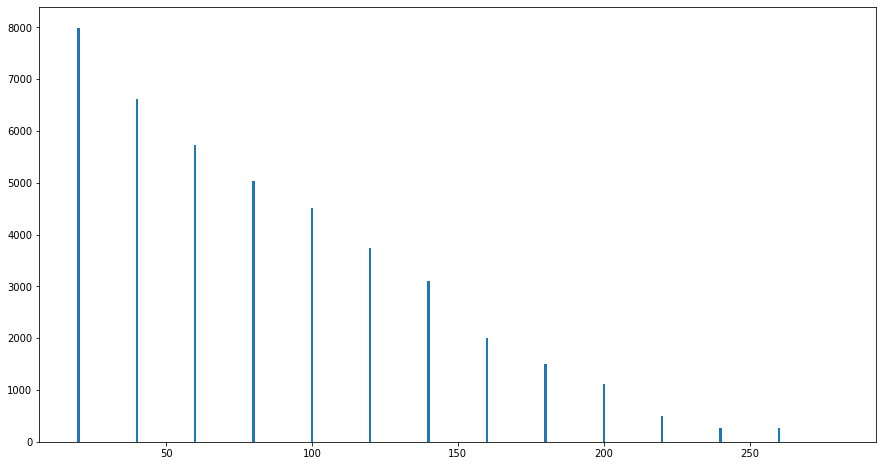

In [204]:
# Samples-per-city cutoff x total dataset size
plt.figure(figsize=(15,8))
plt.bar(cutoff, samplesize)
plt.show()

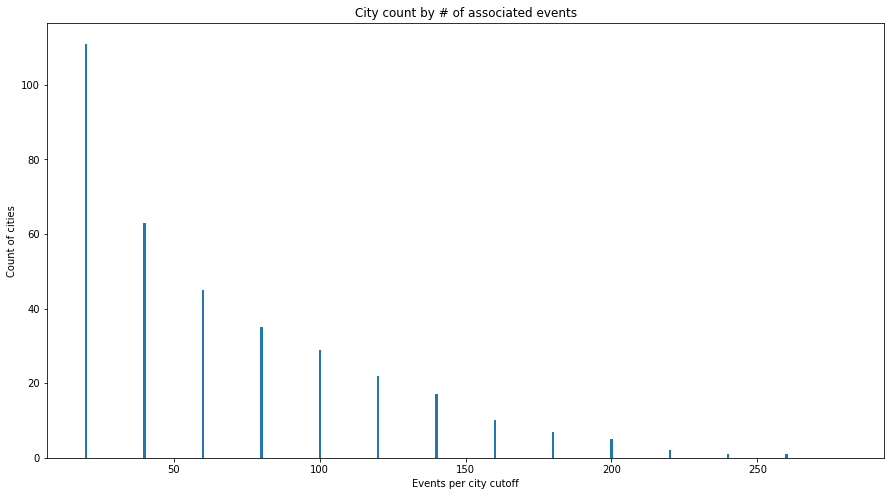

In [248]:
# Samples-per-city cutoff x number of cities leftover
plt.figure(figsize=(15,8))
plt.bar(cutoff, citycount)
plt.ylabel("Count of cities")
plt.xlabel("Events per city cutoff")
plt.title('City count by # of associated events')
plt.show()

In [206]:
df_cut = df_uscity[df_uscity['city'].map(df_uscity['city'].value_counts()) < 125]
df_cut = df_cut[df_cut['city'].map(df_cut['city'].value_counts()) > 30]

In [207]:
df_cut['city'].value_counts()

Charlotte        121
Columbus         117
Indianapolis     116
St Louis         113
Phoenix          109
New York         109
Kansas City      103
Cleveland        101
Baltimore         95
New Orleans       86
Pittsburgh        86
Milwaukee         85
Louisville        84
Sacramento        83
Hollywood         79
Raleigh           78
Orlando           76
Birmingham        69
Grand Rapids      68
Tampa             67
Cincinnati        66
Los Angeles       66
San Antonio       65
Richmond          63
Jacksonville      59
Columbia          59
Anaheim           58
Omaha             53
Santa Ana         53
St. Paul          52
Miami Beach       51
Madison           50
Asbury Park       49
Oakland           49
Oklahoma City     48
Buffalo           47
Rosemont          46
Albuquerque       44
Greensboro        43
Memphis           42
Silver Spring     42
Norfolk           41
Morrison          40
San Jose          39
Tucson            39
Athens            37
Des Moines        37
Spokane      

### Drop 'Miami Beach', 'Los Angeles', 'Hollywood', and 'New York'

In [208]:
df_cut = df_cut[df_cut['city'] != 'Miami Beach']
df_cut = df_cut[df_cut['city'] != 'Los Angeles']
df_cut = df_cut[df_cut['city'] != 'Hollywood']
df_cut = df_cut[df_cut['city'] != 'New York']
df_cut['city'].value_counts()

Charlotte        121
Columbus         117
Indianapolis     116
St Louis         113
Phoenix          109
Kansas City      103
Cleveland        101
Baltimore         95
New Orleans       86
Pittsburgh        86
Milwaukee         85
Louisville        84
Sacramento        83
Raleigh           78
Orlando           76
Birmingham        69
Grand Rapids      68
Tampa             67
Cincinnati        66
San Antonio       65
Richmond          63
Columbia          59
Jacksonville      59
Anaheim           58
Santa Ana         53
Omaha             53
St. Paul          52
Madison           50
Asbury Park       49
Oakland           49
Oklahoma City     48
Buffalo           47
Rosemont          46
Albuquerque       44
Greensboro        43
Memphis           42
Silver Spring     42
Norfolk           41
Morrison          40
San Jose          39
Tucson            39
Athens            37
Spokane           37
Des Moines        37
Knoxville         36
Springfield       36
Boise             35
Greenville   

## Confirm each city maps to only one state
(i.e. Springfield could represent Springfields from multiple states)

### Check which cities are duplicated at the state level

In [209]:
citylist = pd.DataFrame(df_cut['city'].value_counts()).reset_index()['index']

In [210]:
dups = []

for c in citylist:
    num = len(df_cut[df_cut['city'] == c].groupby('state'))
    if num == 1:
        continue
    else:
        dups.append(c)

In [211]:
dups

['Columbus',
 'Cleveland',
 'Richmond',
 'Columbia',
 'Jacksonville',
 'Madison',
 'Athens',
 'Des Moines',
 'Springfield',
 'Greenville',
 'Cambridge',
 'Charleston']

In [212]:
df_cut[df_cut['city'] == 'Charleston'].groupby('state').count()

,artist,genre_complex,genre,artist_id,date,location,popularity,city,country
state,,,,,,,,,
SC,25,25,25,25,25,25,25,25,25
WV,7,7,7,7,7,7,7,7,7


### Cut the duplicated cities that have fewer than 20 associated events

In [213]:
df_citystate = df_cut.groupby(by=['city', 'state']).count().reset_index()

In [214]:
dupecuts = df_citystate[df_citystate['artist'] <= 20]

for c, s in zip(dupecuts['city'], dupecuts['state']):
    df_cut = df_cut[~((df_cut['city'] == c) & (df_cut['state'] == s))]

### Confirm that no more duplicates exist in main dataset

In [215]:
dups = []

for c in citylist:
    num = len(df_cut[df_cut['city'] == c].groupby('state'))
    if num == 1:
        continue
    else:
        dups.append(c)

In [216]:
dups

[]

In [217]:
len(df_cut)

3111

### Group by city and genre to calculate mean genre popularity score by city

In [218]:
df_genscore = pd.DataFrame(df_cut.groupby(by=['city', 'state', 'genre'])['popularity'].mean()).reset_index()
df_genscore.head()

,city,state,genre,popularity
0,Albuquerque,NM,country,0.103392
1,Albuquerque,NM,faith,0.006962
2,Albuquerque,NM,hiphop,0.201966
3,Albuquerque,NM,latin,0.011997
4,Albuquerque,NM,pop,0.146753


## Finalize datasets

### Pivot to create baseline dataset

In [219]:
pvt = pd.pivot_table(df_genscore, index=['city', 'state'], columns='genre',
                     values='popularity', aggfunc='sum', fill_value=0)

In [220]:
pvt.head()

,genre,country,faith,hiphop,latin,pop,rock
city,state,,,,,,
Albuquerque,NM,0.103392,0.006962,0.201966,0.011997,0.146753,0.043656
Anaheim,CA,0.107177,0.012833,0.270516,0.007395,0.230438,0.026071
Asbury Park,NJ,0.007947,0.000000,0.024426,0.000000,0.022083,0.026799
Athens,GA,0.012485,0.000000,0.073950,0.000000,0.045995,0.020373
Baltimore,MD,0.040776,0.064185,0.106361,0.040140,0.036437,0.022700


### Collect maximum values by row, column, and sum of row values for normalization

In [221]:
maxbyrow = []

for i in range(0, 52, 1):
    maxscore = float(pvt.iloc[i].max())
    maxbyrow.append(maxscore)

In [222]:
maxbycol = []

for i in pvt:
    maxscore = pvt[i].max()
    maxbycol.append(maxscore)

In [223]:
sumbyrow = []

for i in range(0, 52, 1):
    sumscore = float(pvt.iloc[i].sum())
    sumbyrow.append(sumscore)

### Create 2 new pivot tables, normalized by row, column, and row sum respectively

#### By row

In [224]:
normedrows = []

for n, m in enumerate(maxbyrow):
        normedrow = []
        for v in pvt.iloc[n]:
            normed = v/m
            normedrow.append(normed)
        normedrows.append(normedrow)   

In [225]:
pvt_nrow = pd.DataFrame(normedrows, index=pvt.index, columns=pvt.columns)

In [226]:
pvt_nrow.head()

,genre,country,faith,hiphop,latin,pop,rock
city,state,,,,,,
Albuquerque,NM,0.511925,0.034471,1.000000,0.059401,0.726624,0.216154
Anaheim,CA,0.396195,0.047440,1.000000,0.027337,0.851847,0.096376
Asbury Park,NJ,0.296547,0.000000,0.911426,0.000000,0.824003,1.000000
Athens,GA,0.168829,0.000000,1.000000,0.000000,0.621974,0.275498
Baltimore,MD,0.383372,0.603463,1.000000,0.377393,0.342582,0.213424


#### By column

In [227]:
normedcols = []

for n, m in enumerate(maxbycol):
        normedcol = []
        for v in pvt.iloc[:,n]:
            normed = v/m
            normedcol.append(normed)
        normedcols.append(normedcol)  

In [228]:
pvt_ncol = pd.DataFrame(normedcols, index=pvt.columns).T

In [229]:
pvt_ncol.set_index(pvt.index, inplace=True)

In [230]:
pvt_ncol.head()

,genre,country,faith,hiphop,latin,pop,rock
city,state,,,,,,
Albuquerque,NM,0.245707,0.072203,0.476667,0.078007,0.386469,0.497851
Anaheim,CA,0.254704,0.133092,0.638455,0.048084,0.606850,0.297318
Asbury Park,NJ,0.018886,0.000000,0.057648,0.000000,0.058154,0.305622
Athens,GA,0.029670,0.000000,0.174532,0.000000,0.121126,0.232335
Baltimore,MD,0.096903,0.665661,0.251026,0.261000,0.095956,0.258873


#### By the sum of all values in a given row

In [231]:
normedrowsums = []

for n, m in enumerate(sumbyrow):
        normedrowsum = []
        for v in pvt.iloc[n]:
            normed = v/m
            normedrowsum.append(normed)
        normedrowsums.append(normedrowsum)  

In [232]:
pvt_nrowsum = pd.DataFrame(normedrowsums, index=pvt.index, columns=pvt.columns)

In [233]:
pvt_nrowsum.head()

,genre,country,faith,hiphop,latin,pop,rock
city,state,,,,,,
Albuquerque,NM,0.200867,0.013526,0.392376,0.023308,0.285110,0.084813
Anaheim,CA,0.163771,0.019610,0.413361,0.011300,0.352120,0.039838
Asbury Park,NJ,0.097807,0.000000,0.300604,0.000000,0.271771,0.329818
Athens,GA,0.081706,0.000000,0.483957,0.000000,0.301009,0.133329
Baltimore,MD,0.131281,0.206649,0.342438,0.129234,0.117313,0.073085


## Store formatted data to .csv files

In [234]:
pvt.to_csv('data_v2/pvt.csv', )
pvt_nrow.to_csv('data_v2/pvt_nrow.csv')
pvt_ncol.to_csv('data_v2/pvt_ncol.csv')
pvt_nrowsum.to_csv('data_v2/pvt_nrowsum.csv')

# Clustering

In [235]:
from sklearn.cluster import KMeans
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity

In [236]:
pvt = pd.read_csv('data_v2/pvt.csv')
pvt.set_index(['city', 'state'], inplace=True)

pvt_nrow = pd.read_csv('data_v2/pvt_nrow.csv')
pvt_nrow.set_index(['city', 'state'], inplace=True)

pvt_ncol = pd.read_csv('data_v2/pvt_ncol.csv')
pvt_ncol.set_index(['city', 'state'], inplace=True)

pvt_nrs = pd.read_csv('data_v2/pvt_nrowsum.csv')
pvt_nrs.set_index(['city', 'state'], inplace=True)

## K Means
### Unnormalized data

In [237]:
k_means_3 = KMeans(n_clusters=3, random_state=29).fit(pvt)
k_means_4 = KMeans(n_clusters=4, random_state=29).fit(pvt)
k_means_5 = KMeans(n_clusters=5, random_state=29).fit(pvt)
k_means_6 = KMeans(n_clusters=6, random_state=29).fit(pvt)
k_means_7 = KMeans(n_clusters=7, random_state=29).fit(pvt)
k_means_8 = KMeans(n_clusters=8, random_state=29).fit(pvt)
k_means_9 = KMeans(n_clusters=9, random_state=29).fit(pvt)
k_means_10 = KMeans(n_clusters=10, random_state=29).fit(pvt)
k_means_11 = KMeans(n_clusters=11, random_state=29).fit(pvt)
k_means_12 = KMeans(n_clusters=12, random_state=29).fit(pvt)
k_means_13 = KMeans(n_clusters=13, random_state=29).fit(pvt)
k_means_14 = KMeans(n_clusters=14, random_state=29).fit(pvt)
k_means_15 = KMeans(n_clusters=15, random_state=29).fit(pvt)

k_list = [k_means_3, k_means_4, k_means_5, k_means_6, k_means_7, k_means_8, k_means_9, k_means_10, k_means_11,
          k_means_12, k_means_13, k_means_14, k_means_15]

In [238]:
CH_score = []

for k in k_list:
    lab = k.labels_
    ch = calinski_harabasz_score(pvt, lab)
    CH_score.append(ch)

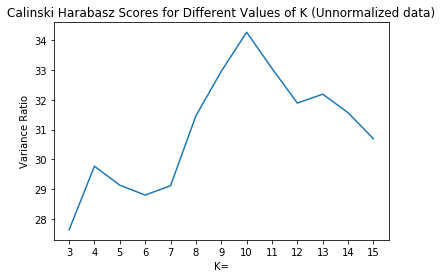

In [239]:
x = range(3, 16, 1)

plt.plot(x, CH_score)
plt.xticks(x)
plt.title('Calinski Harabasz Scores for Different Values of K (Unnormalized data)')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [241]:
wcss_score = []

for k in k_list:
    inert = k.inertia_
    wcss_score.append(inert)

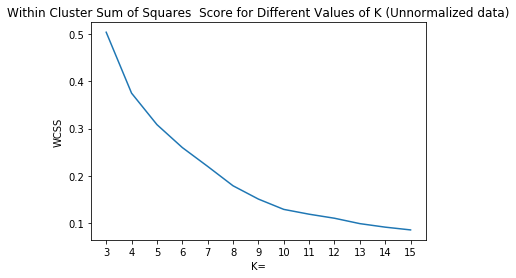

In [242]:
x = range(3, 16, 1)

plt.plot(x, wcss_score)
plt.xticks(x)
plt.title('Within Cluster Sum of Squares  Score for Different Values of K (Unnormalized data)')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

### Normalized by row

In [331]:
k_means_row_3 = KMeans(n_clusters=3, random_state=29).fit(pvt_nrow)
k_means_row_4 = KMeans(n_clusters=4, random_state=29).fit(pvt_nrow)
k_means_row_5 = KMeans(n_clusters=5, random_state=29).fit(pvt_nrow)
k_means_row_6 = KMeans(n_clusters=6, random_state=29).fit(pvt_nrow)
k_means_row_7 = KMeans(n_clusters=7, random_state=29).fit(pvt_nrow)
k_means_row_8 = KMeans(n_clusters=8, random_state=29).fit(pvt_nrow)
k_means_row_9 = KMeans(n_clusters=9, random_state=29).fit(pvt_nrow)
k_means_row_10 = KMeans(n_clusters=10, random_state=29).fit(pvt_nrow)
k_means_row_11 = KMeans(n_clusters=11, random_state=29).fit(pvt_nrow)
k_means_row_12 = KMeans(n_clusters=12, random_state=29).fit(pvt_nrow)
k_means_row_13 = KMeans(n_clusters=13, random_state=29).fit(pvt_nrow)
k_means_row_14 = KMeans(n_clusters=14, random_state=29).fit(pvt_nrow)
k_means_row_15 = KMeans(n_clusters=15, random_state=29).fit(pvt_nrow)

k_list_row = [k_means_row_3, k_means_row_4, k_means_row_5, k_means_row_6, k_means_row_7, k_means_row_8, 
              k_means_row_9, k_means_row_10, k_means_row_11, k_means_row_12, k_means_row_13, k_means_row_14, 
              k_means_row_15]

In [332]:
CH_score_row = []

for k in k_list_row:
    lab = k.labels_
    ch = calinski_harabasz_score(pvt_nrow, lab)
    CH_score_row.append(ch)

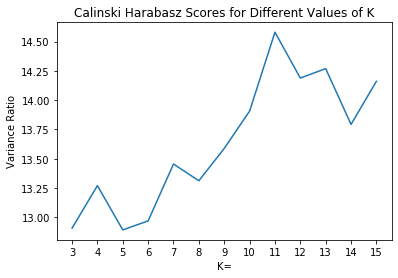

In [333]:
x = range(3, 16, 1)

plt.plot(x, CH_score_row)
plt.xticks(x)
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [334]:
wcss_score_row = []

for k in k_list_row:
    inert = k.inertia_
    wcss_score_row.append(inert)

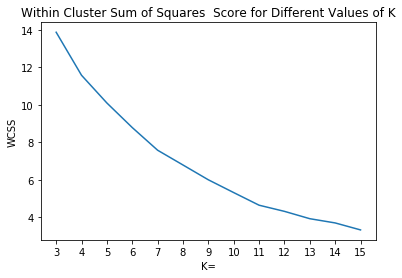

In [335]:
x = range(3, 16, 1)

plt.plot(x, wcss_score_row)
plt.xticks(x)
plt.title('Within Cluster Sum of Squares  Score for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

### Normalized by column

In [336]:
k_means_col_3 = KMeans(n_clusters=3, random_state=29).fit(pvt_ncol)
k_means_col_4 = KMeans(n_clusters=4, random_state=29).fit(pvt_ncol)
k_means_col_5 = KMeans(n_clusters=5, random_state=29).fit(pvt_ncol)
k_means_col_6 = KMeans(n_clusters=6, random_state=29).fit(pvt_ncol)
k_means_col_7 = KMeans(n_clusters=7, random_state=29).fit(pvt_ncol)
k_means_col_8 = KMeans(n_clusters=8, random_state=29).fit(pvt_ncol)
k_means_col_9 = KMeans(n_clusters=9, random_state=29).fit(pvt_ncol)
k_means_col_10 = KMeans(n_clusters=10, random_state=29).fit(pvt_ncol)
k_means_col_11 = KMeans(n_clusters=11, random_state=29).fit(pvt_ncol)
k_means_col_12 = KMeans(n_clusters=12, random_state=29).fit(pvt_ncol)
k_means_col_13 = KMeans(n_clusters=13, random_state=29).fit(pvt_ncol)
k_means_col_14 = KMeans(n_clusters=14, random_state=29).fit(pvt_ncol)
k_means_col_15 = KMeans(n_clusters=15, random_state=29).fit(pvt_ncol)

k_list_col = [k_means_col_3, k_means_col_4, k_means_col_5, k_means_col_6, k_means_col_7, k_means_col_8, 
              k_means_col_9, k_means_col_10, k_means_col_11, k_means_col_12, k_means_col_13, k_means_col_14, 
              k_means_col_15]

In [337]:
CH_score_col = []

for k in k_list_col:
    lab = k.labels_
    ch = calinski_harabasz_score(pvt_ncol, lab)
    CH_score_col.append(ch)

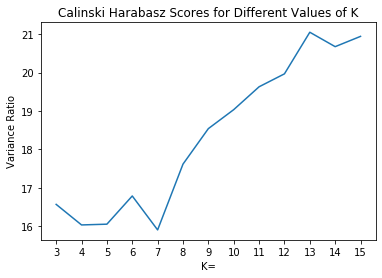

In [338]:
x = range(3, 16, 1)

plt.plot(x, CH_score_col)
plt.xticks(x)
plt.title('Calinski Harabasz Scores for Different Values of K')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [339]:
wcss_score_col = []

for k in k_list_col:
    inert = k.inertia_
    wcss_score_col.append(inert)

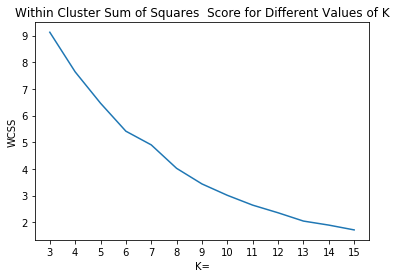

In [340]:
x = range(3, 16, 1)

plt.plot(x, wcss_score_col)
plt.xticks(x)
plt.title('Within Cluster Sum of Squares  Score for Different Values of K')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

### Normalized by row sum

In [243]:
k_means_nrs_3 = KMeans(n_clusters=3, random_state=29).fit(pvt_nrs)
k_means_nrs_4 = KMeans(n_clusters=4, random_state=29).fit(pvt_nrs)
k_means_nrs_5 = KMeans(n_clusters=5, random_state=29).fit(pvt_nrs)
k_means_nrs_6 = KMeans(n_clusters=6, random_state=29).fit(pvt_nrs)
k_means_nrs_7 = KMeans(n_clusters=7, random_state=29).fit(pvt_nrs)
k_means_nrs_8 = KMeans(n_clusters=8, random_state=29).fit(pvt_nrs)
k_means_nrs_9 = KMeans(n_clusters=9, random_state=29).fit(pvt_nrs)
k_means_nrs_10 = KMeans(n_clusters=10, random_state=29).fit(pvt_nrs)
k_means_nrs_11 = KMeans(n_clusters=11, random_state=29).fit(pvt_nrs)
k_means_nrs_12 = KMeans(n_clusters=12, random_state=29).fit(pvt_nrs)
k_means_nrs_13 = KMeans(n_clusters=13, random_state=29).fit(pvt_nrs)
k_means_nrs_14 = KMeans(n_clusters=14, random_state=29).fit(pvt_nrs)
k_means_nrs_15 = KMeans(n_clusters=15, random_state=29).fit(pvt_nrs)

k_list_nrs = [k_means_nrs_3, k_means_nrs_4, k_means_nrs_5, k_means_nrs_6, k_means_nrs_7, k_means_nrs_8, 
              k_means_nrs_9, k_means_nrs_10, k_means_nrs_11, k_means_nrs_12, k_means_nrs_13, k_means_nrs_14, 
              k_means_nrs_15]

In [244]:
CH_score_nrs = []

for k in k_list_nrs:
    lab = k.labels_
    ch = calinski_harabasz_score(pvt_nrs, lab)
    CH_score_nrs.append(ch)

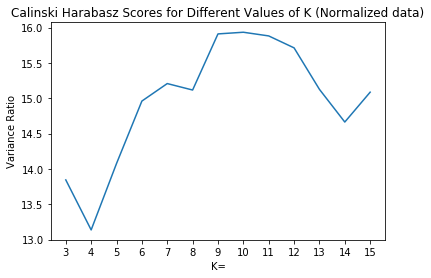

In [245]:
x = range(3, 16, 1)

plt.plot(x, CH_score_nrs)
plt.xticks(x)
plt.title('Calinski Harabasz Scores for Different Values of K (Normalized data)')
plt.ylabel('Variance Ratio')
plt.xlabel('K=')
plt.show()

In [246]:
wcss_score_nrs = []

for k in k_list_nrs:
    inert = k.inertia_
    wcss_score_nrs.append(inert)

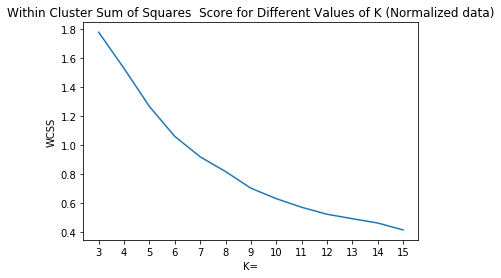

In [247]:
x = range(3, 16, 1)

plt.plot(x, wcss_score_nrs)
plt.xticks(x)
plt.title('Within Cluster Sum of Squares  Score for Different Values of K (Normalized data)')
plt.ylabel('WCSS')
plt.xlabel('K=')
plt.show()

### Conclusions
- Unnormalized:  optimized at 10 clusters 
- Normalized by row:  optimized at 11 clusters
- Normalized by column:  optimized at 13 clusters
- Normalized by row sum:  optimized at 9 or 10 clusters

## Heirarchical Agglomerative

### Unnormalized data

In [84]:
linkage_ward = ward(pvt)
linkage_avg = average(pvt)
linkage_comp = complete(pvt)

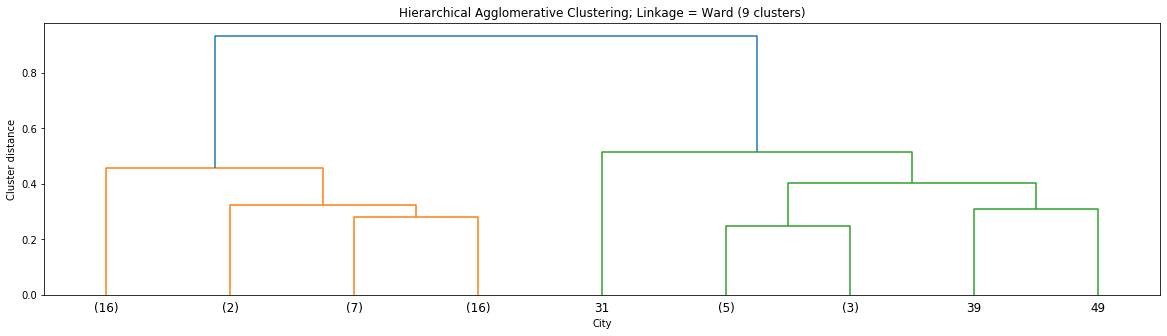

In [193]:
# Formatted for ppt presentation
fig = plt.figure(figsize=(20, 5))
ax = fig.gca()
dendrogram(linkage_ward, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('City')
plt.ylabel('Cluster distance')
plt.title('Hierarchical Agglomerative Clustering; Linkage = Ward (9 clusters)');

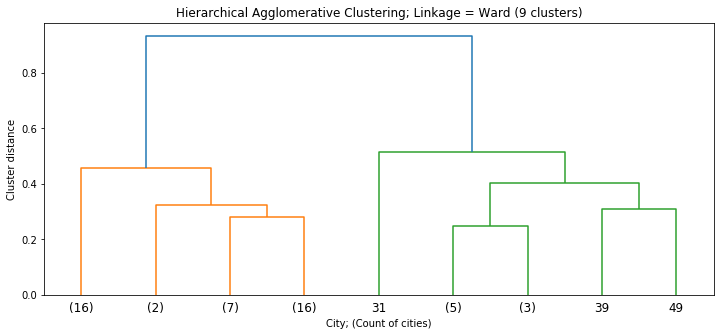

In [190]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_ward, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('City; (Count of cities)')
plt.ylabel('Cluster distance')
plt.title('Hierarchical Agglomerative Clustering; Linkage = Ward (9 clusters)');

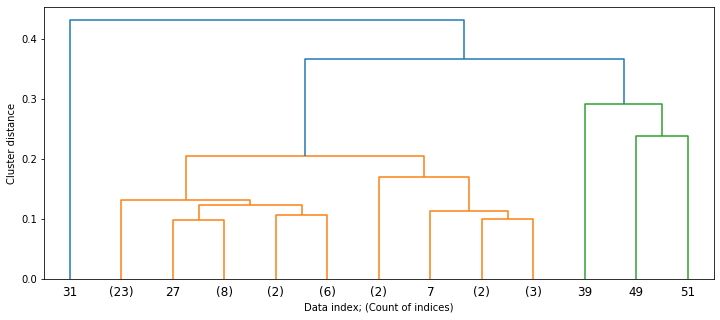

In [87]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_avg, ax=ax, truncate_mode='lastp', p=13)
plt.xlabel('Data index; (Count of indices)')
plt.ylabel('Cluster distance');

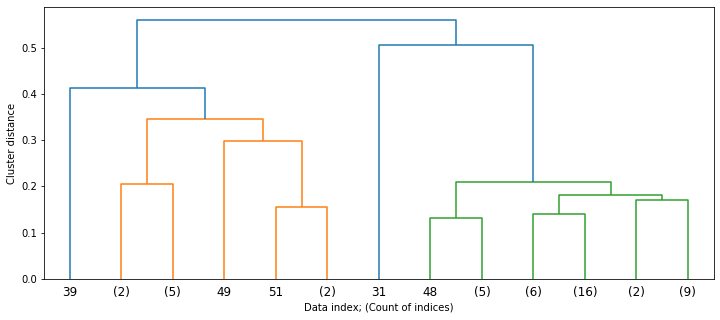

In [88]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_comp, ax=ax, truncate_mode='lastp', p=13)
plt.xlabel('Data index; (Count of indices)')
plt.ylabel('Cluster distance');

In [91]:
agg_comp = AgglomerativeClustering(linkage ='complete', n_clusters=10)
agg_avg = AgglomerativeClustering(linkage ='average', n_clusters=10)
agg_ward = AgglomerativeClustering(linkage ='ward', n_clusters=10)

as_comp = agg_comp.fit_predict(pvt)
as_avg = agg_avg.fit_predict(pvt)
as_ward = agg_ward.fit_predict(pvt)

### Normalized by row sum

In [92]:
linkage_ward_nrs = ward(pvt_nrs)
linkage_avg_nrs = average(pvt_nrs)
linkage_comp_nrs = complete(pvt_nrs)

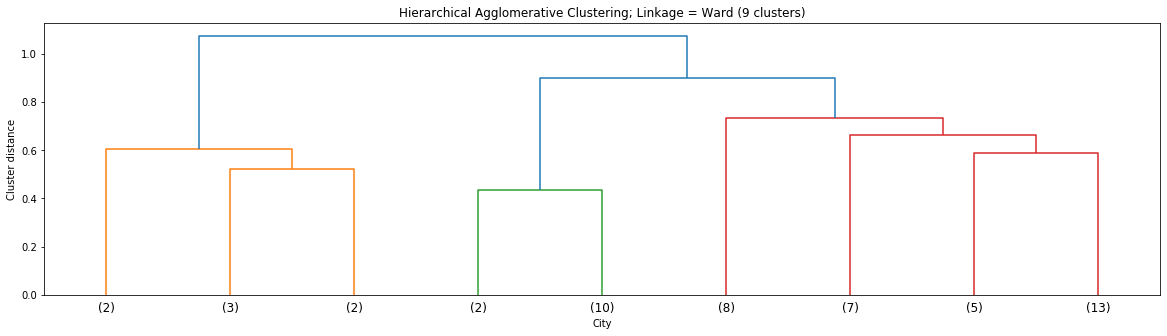

In [196]:
# Formatted for ppt presentation

fig = plt.figure(figsize=(20, 5))
ax = fig.gca()
dendrogram(linkage_ward_nrs, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('City')
plt.ylabel('Cluster distance')
plt.title('Hierarchical Agglomerative Clustering; Linkage = Ward (9 clusters)');

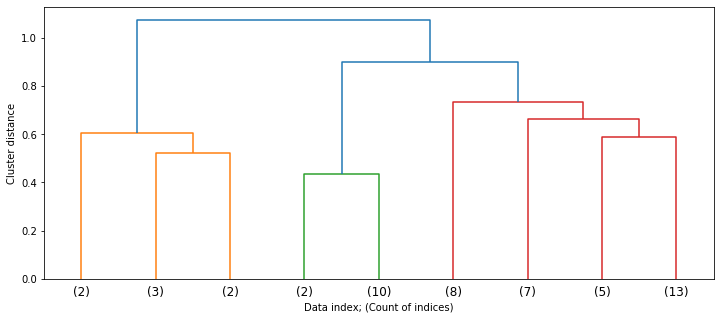

In [194]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_ward_nrs, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('Data index; (Count of indices)')
plt.ylabel('Cluster distance');

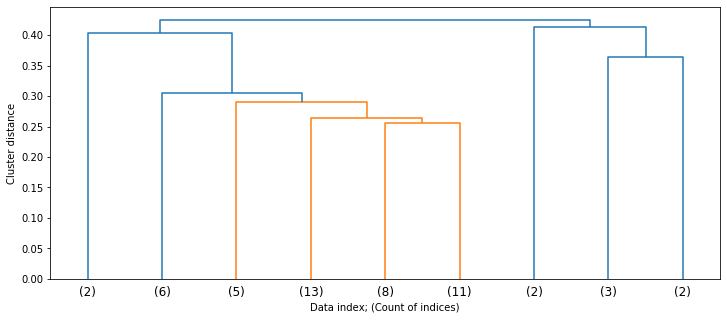

In [102]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_avg_nrs, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('Data index; (Count of indices)')
plt.ylabel('Cluster distance');

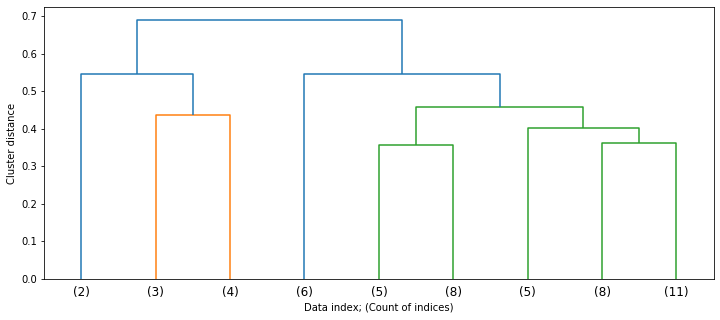

In [103]:
fig = plt.figure(figsize=(12, 5))
ax = fig.gca()
dendrogram(linkage_comp_nrs, ax=ax, truncate_mode='lastp', p=9)
plt.xlabel('Data index; (Count of indices)')
plt.ylabel('Cluster distance');

In [104]:
agg_comp_9 = AgglomerativeClustering(linkage ='complete', n_clusters=9)
agg_avg_9 = AgglomerativeClustering(linkage ='average', n_clusters=9)
agg_ward_9 = AgglomerativeClustering(linkage ='ward', n_clusters=9)

agg_comp_10 = AgglomerativeClustering(linkage ='complete', n_clusters=10)
agg_avg_10 = AgglomerativeClustering(linkage ='average', n_clusters=10)
agg_ward_10 = AgglomerativeClustering(linkage ='ward', n_clusters=10)

as_comp_9 = agg_comp_9.fit_predict(pvt_nrs)
as_avg_9 = agg_avg_9.fit_predict(pvt_nrs)
as_ward_9 = agg_ward_9.fit_predict(pvt_nrs)

as_comp_10 = agg_comp_10.fit_predict(pvt_nrs)
as_avg_10 = agg_avg_10.fit_predict(pvt_nrs)
as_ward_10 = agg_ward_10.fit_predict(pvt_nrs)

### Conclusions
- Normalized by row sum results in the most evenly distributed clusters by cluster size
- Ward and Complete were the two linkage criteria that resulted in the most evenly distributed clusters by cluster size
- Hard to tell whether 9 or 10 clusters is optimal

## Compare results

In [110]:
labels_kmeans_9 = k_means_nrs_9.labels_
labels_comp_9 = agg_comp_9.labels_
labels_ward_9 = agg_ward_9.labels_

labels_kmeans_10 = k_means_nrs_10.labels_
labels_comp_10 = agg_comp_10.labels_
labels_ward_10 = agg_ward_10.labels_

labels = [labels_kmeans_9, labels_comp_9, labels_ward_9, labels_kmeans_10, labels_comp_10, labels_ward_10]

In [115]:
chscores = []
silscores = []
descriptions = ["KM (9 clusters)", "HA-Complete (9 clusters)", "HA-Ward (9 clusters)", 
                "KM (10 clusters)", "HA-Complete (10 clusters)", "HA-Ward (10 clusters)"]

for n, l in enumerate(labels):
    chscore = metrics.calinski_harabasz_score(pvt_nrs, l)
    silscore = metrics.silhouette_score(pvt_nrs, l)
    chscores.append((descriptions[n], chscore))
    silscores.append((descriptions[n], silscore))

In [125]:
chscores

[('KM (9 clusters)', 15.911100403131108),
 ('HA-Complete (9 clusters)', 13.983659088678312),
 ('HA-Ward (9 clusters)', 15.227261248794647),
 ('KM (10 clusters)', 15.93471650211448),
 ('HA-Complete (10 clusters)', 14.492797926331667),
 ('HA-Ward (10 clusters)', 15.595316544743525)]

In [117]:
silscores

[('KM (9 clusters)', 0.2807915818595869),
 ('HA-Complete (9 clusters)', 0.24346520949165257),
 ('HA-Ward (9 clusters)', 0.29132870020595203),
 ('KM (10 clusters)', 0.26238248546042814),
 ('HA-Complete (10 clusters)', 0.2540489946511961),
 ('HA-Ward (10 clusters)', 0.2787829074183221)]

### Conclusions
- Heirarchical agglomerative clustering with the linkage function set to Complete performed the worst, regardless of cluster count
- The Silhouette scores point towards 9 clusters as being the optimal grouping 
- The Calinski-Harabasz scores point towards 10 clusters as being the optimal grouping
- Based on Silhouette score, HA-Ward with 9 clusters was the optimal 
- Based on the CH score, K-Means clustering with 10 clusters was the optimal 

# Analysis

In [149]:
df_ward9 = pd.DataFrame(labels_ward_9, index=pvt_nrs.index, columns=['labels_ward_9'])
df_ward10 = pd.DataFrame(labels_ward_10, index=pvt_nrs.index, columns=['labels_ward_10'])
df_kmeans10 = pd.DataFrame(labels_kmeans_10, index=pvt_nrs.index, columns=['labels_kmeans_10'])

In [165]:
df_lab_ward9 = pd.concat([pvt_nrs, df_ward9], axis=1)
df_lab_ward10 = pd.concat([pvt_nrs, df_ward10], axis=1)
df_lab_kmeans10 = pd.concat([pvt_nrs, df_kmeans10], axis=1)

In [186]:
df_lab_ward9.groupby('labels_ward_9').mean().round(2)

,country,faith,hiphop,latin,pop,rock
labels_ward_9,,,,,,
0,0.19,0.15,0.27,0.01,0.29,0.11
1,0.14,0.11,0.27,0.16,0.24,0.08
2,0.47,0.08,0.28,0.06,0.06,0.05
3,0.12,0.02,0.42,0.02,0.33,0.08
4,0.12,0.02,0.24,0.02,0.34,0.26
5,0.21,0.35,0.17,0.00,0.05,0.21
6,0.09,0.15,0.21,0.01,0.47,0.08
7,0.20,0.12,0.46,0.02,0.05,0.15
8,0.04,0.08,0.23,0.36,0.18,0.11


In [ ]:
3:  Hiphop (Pop)
7:  Hiphop (Country, Rock)
6:  Pop (Hiphop)
2:  Country (Hiphop)
8:  Latin (Hiphop) 
5:  Faith (Rock, Country)
4:  Rock, Pop, Hiphop


0:  Pop, Hiphop (Country)
1:  Hiphop, Pop (Latin)


In [176]:
df_lab_ward10.groupby('labels_ward_10').mean()

,country,faith,hiphop,latin,pop,rock
labels_ward_10,,,,,,
0,0.234639,0.132153,0.228385,0.004176,0.281438,0.119209
1,0.139059,0.105970,0.271150,0.158744,0.244496,0.080581
2,0.466217,0.084941,0.280177,0.058876,0.055706,0.054082
3,0.121617,0.024434,0.423024,0.016645,0.332091,0.082189
4,0.123665,0.022123,0.235147,0.017866,0.338087,0.263111
5,0.210176,0.353986,0.173368,0.000000,0.050933,0.211537
6,0.087195,0.145503,0.205954,0.007528,0.469643,0.084177
7,0.199665,0.118995,0.458890,0.021997,0.054324,0.146129
8,0.042798,0.075746,0.229321,0.358435,0.180341,0.113358


In [ ]:
0:  Pop, Country, Hiphop
1:  Hiphop, Pop (Latin)
2:  Country, Hiphop
3:  Hiphop, Pop (Country)
4:  Pop, Rock, Hiphop
5:  Faith, Rock, Country
6:  Pop, Hiphop (Faith)
7:  Hiphop, Country (Rock)
8:  Latin, Hiphop (Pop)
9:  Hiphop, Pop, Faith

In [177]:
df_lab_kmeans10.groupby('labels_kmeans_10').mean()

,country,faith,hiphop,latin,pop,rock
labels_kmeans_10,,,,,,
0,0.092863,0.134992,0.201833,0.028510,0.455270,0.086532
1,0.199665,0.118995,0.458890,0.021997,0.054324,0.146129
2,0.148810,0.046012,0.226435,0.013896,0.314746,0.250101
3,0.135076,0.174238,0.298002,0.013566,0.292309,0.086810
4,0.204439,0.343706,0.173846,0.000000,0.105882,0.172127
5,0.141042,0.108586,0.281142,0.161557,0.229062,0.078612
6,0.042798,0.075746,0.229321,0.358435,0.180341,0.113358
7,0.466217,0.084941,0.280177,0.058876,0.055706,0.054082
8,0.247624,0.029870,0.286541,0.000000,0.340041,0.095924


In [ ]:
0:  Pop, (Hiphop)
1:  Hiphop (Country, Rock)
2:  Pop, Rock, Hiphop
3:  Hiphop, Pop (Faith)
4:  Faith, Country
5:  Hiphop, Pop (Latin)
6:  Latin, Hiphop (Pop)
7:  Country, Hiphop
8:  Pop, Hiphop, Country
9:  Hiphop, Pop

In [182]:
df_final = df_lab_ward9.reset_index()
df_final

,city,state,country,faith,hiphop,latin,pop,rock,labels_ward_9
0,Albuquerque,NM,0.200867,0.013526,0.392376,0.023308,0.285110,0.084813,3
1,Anaheim,CA,0.163771,0.019610,0.413361,0.011300,0.352120,0.039838,3
2,Asbury Park,NJ,0.097807,0.000000,0.300604,0.000000,0.271771,0.329818,4
3,Athens,GA,0.081706,0.000000,0.483957,0.000000,0.301009,0.133329,3
4,Baltimore,MD,0.131281,0.206649,0.342438,0.129234,0.117313,0.073085,1
5,Birmingham,AL,0.109303,0.209340,0.294146,0.000000,0.251255,0.135956,0
6,Boise,ID,0.288055,0.096043,0.190640,0.000000,0.234433,0.190829,0
7,Buffalo,NY,0.094585,0.156836,0.339586,0.000000,0.374656,0.034337,0
8,Cambridge,MA,0.064503,0.000000,0.211436,0.000000,0.456985,0.267077,4
9,Charleston,SC,0.204202,0.000000,0.281011,0.000000,0.277923,0.236863,4
